## Task 2: Experiment with Initialization, Regularization and Optimizers
***
**Implementation specifics:**
- Validation data kept separate in this task as well, in order to keep parity between Network 2 of Task 1 and the models being trained in this task
- All models run for 50 epochs
- Direct use of APIs done for the optimizers
- Learning rate kept at 0.001 as before
- Accuracies printed while training
- Varying parameters of the initializers could significantly change the results

In [2]:
from zipfile import ZipFile
import numpy as np
import mxnet as mx

display_step=10

In [3]:
class DataLoader(object):
    DIR=None
    import os
    print(os.getcwd())
    
    def __init__(self):
        self.DIR = './'
    
    # Returns images and labels corresponding for training and testing. Default mode is train. 
    # For retrieving test data pass mode as 'test' in function call.
    def load_data(self, mode = 'train'):
        label_filename = mode + '_labels'
        image_filename = mode + '_images'
        label_zip = self.DIR + label_filename + '.zip'
        image_zip = self.DIR + image_filename + '.zip'
        with ZipFile(label_zip, 'r') as lblzip:
            labels = np.frombuffer(lblzip.read(label_filename), dtype=np.uint8, offset=8)
        with ZipFile(image_zip, 'r') as imgzip:
            images = np.frombuffer(imgzip.read(image_filename), dtype=np.uint8, offset=16).reshape(len(labels), 784)
        return images, labels
    
    
    def create_batches(self,train_size):
        '''
        Handles the train-validation split 
        Params:
            train_size: ratio of train_size : float
        Returns:
            images, labels, validation images, validation labels in that order
        '''
        img,labels=self.load_data()
        n=labels.shape[0]
        #split into train and validation data
        validation_img=img[int(train_size*n):]
        img=img[:int(train_size*n)]
        validation_labels=labels[int(train_size*n):]
        labels=labels[:int(train_size*n)]
        return img, labels, validation_img, validation_labels        

/home/bt3/15CS10057/dl


In [4]:
data_loader=DataLoader()
data,label,val_data,val_labels=data_loader.create_batches(train_size=0.7)
batch_size = 100
ntrain = int(data.shape[0]*0.8)
train_iter = mx.io.NDArrayIter(data, label, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(val_data, val_labels,batch_size=val_data.shape[0])

In [5]:
n_epochs=50
data_2 = mx.symbol.Variable('data')
fc1_2  = mx.symbol.FullyConnected(data = data_2, num_hidden=1024)
act1_2 = mx.symbol.Activation(data = fc1_2, act_type="relu")
fc2_2  = mx.symbol.FullyConnected(data = act1_2, num_hidden = 512)
act2_2 = mx.symbol.Activation(data = fc2_2, act_type="relu")
fc3_2  = mx.symbol.FullyConnected(data = act2_2, num_hidden = 256)
act3_2 = mx.symbol.Activation(data = fc3_2, act_type="relu")

#output layer
fc4_2  = mx.symbol.FullyConnected(data = act3_2, num_hidden=10)
mlp_2 = mx.symbol.SoftmaxOutput(data = fc4_2,name='softmax')

***
### Experiment 1

#### Normal Initialization

In [14]:
normal_init=[]
mod = mx.mod.Module(symbol=mlp_2,
                    context=mx.cpu(),
                    data_names=['data'],
                    label_names=['softmax_label'])

# allocate memory given the input data and label shapes
mod.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
mod.init_params(mx.initializer.Normal(0.01))
learn_rate=0.001
mod.init_optimizer(optimizer='sgd', optimizer_params=(('learning_rate', learn_rate), ))
# use accuracy as the metric
metric = mx.metric.CrossEntropy()
metric2= mx.metric.create('acc')
for epoch in range(n_epochs):
    train_iter.reset()
    metric.reset()
    metric2.reset()
    for batch in train_iter:
        mod.forward(batch, is_train=True)       # compute predictions
        mod.update_metric(metric, batch.label)  # accumulate prediction loss
        mod.update_metric(metric2, batch.label)  # accumulate prediction accuracy
        mod.backward()                          # compute gradients
        mod.update()                            # update parameters
    loss=metric.get()
    acc=metric2.get()
    normal_init.append(loss)
    if epoch%display_step==0 or epoch==n_epochs-1:
        print('Epoch %d, Training %s' % (epoch+1,acc))

Epoch 1, Training ('accuracy', 0.66466666666666663)
Epoch 11, Training ('accuracy', 0.86850000000000005)
Epoch 21, Training ('accuracy', 0.89069047619047614)
Epoch 31, Training ('accuracy', 0.90835714285714286)
Epoch 41, Training ('accuracy', 0.92528571428571427)
Epoch 50, Training ('accuracy', 0.93778571428571433)


***
#### Xavier Initialization

In [15]:
xavier_init=[]
mod = mx.mod.Module(symbol=mlp_2,
                    context=mx.cpu(),
                    data_names=['data'],
                    label_names=['softmax_label'])

# allocate memory given the input data and label shapes
mod.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
mod.init_params(mx.initializer.Xavier(factor_type="in", magnitude=2.34))
learn_rate=0.001
mod.init_optimizer(optimizer='sgd', optimizer_params=(('learning_rate', learn_rate), ))
# use accuracy as the metric
metric = mx.metric.CrossEntropy()
metric2= mx.metric.create('acc')
for epoch in range(n_epochs):
    train_iter.reset()
    metric.reset()
    metric2.reset()
    for batch in train_iter:
        mod.forward(batch, is_train=True)       # compute predictions
        mod.update_metric(metric, batch.label)  # accumulate prediction loss
        mod.update_metric(metric2, batch.label)  # accumulate prediction accuracy
        mod.backward()                          # compute gradients
        mod.update()                            # update parameters
    loss=metric.get()
    acc=metric2.get()
    xavier_init.append(loss)
    if epoch%display_step==0 or epoch==n_epochs-1:
        print('Epoch %d, Training %s' % (epoch+1,acc))

Epoch 1, Training ('accuracy', 0.76530952380952377)
Epoch 11, Training ('accuracy', 0.91880952380952385)
Epoch 21, Training ('accuracy', 0.95002380952380949)
Epoch 31, Training ('accuracy', 0.96999999999999997)
Epoch 41, Training ('accuracy', 0.98371428571428576)
Epoch 50, Training ('accuracy', 0.99152380952380947)


***
#### Orthogonal Initialization

In [16]:
ortho_init=[]
mod = mx.mod.Module(symbol=mlp_2,
                    context=mx.cpu(),
                    data_names=['data'],
                    label_names=['softmax_label'])

# allocate memory given the input data and label shapes
mod.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
mod.init_params(mx.initializer.Orthogonal())
learn_rate=0.001
mod.init_optimizer(optimizer='sgd', optimizer_params=(('learning_rate', learn_rate), ))
# use accuracy as the metric
metric = mx.metric.CrossEntropy()
metric2= mx.metric.create('acc')
for epoch in range(n_epochs):
    train_iter.reset()
    metric.reset()
    metric2.reset()
    for batch in train_iter:
        mod.forward(batch, is_train=True)       # compute predictions
        mod.update_metric(metric, batch.label)  # accumulate prediction loss
        mod.update_metric(metric2, batch.label)  # accumulate prediction accuracy
        mod.backward()                          # compute gradients
        mod.update()                            # update parameters
    loss=metric.get()
    acc=metric2.get()
    ortho_init.append(loss)
    if epoch%display_step==0 or epoch==n_epochs-1:
        print('Epoch %d, Training %s' % (epoch+1,acc))

Epoch 1, Training ('accuracy', 0.68757142857142861)
Epoch 11, Training ('accuracy', 0.87447619047619052)
Epoch 21, Training ('accuracy', 0.89728571428571424)
Epoch 31, Training ('accuracy', 0.9103809523809524)
Epoch 41, Training ('accuracy', 0.92026190476190473)
Epoch 50, Training ('accuracy', 0.92792857142857144)


### Loading network 2 data:

In [22]:
import pickle
train_2_loss=pickle.load(open('train_2_loss','rb'))

### Plotting relevant data

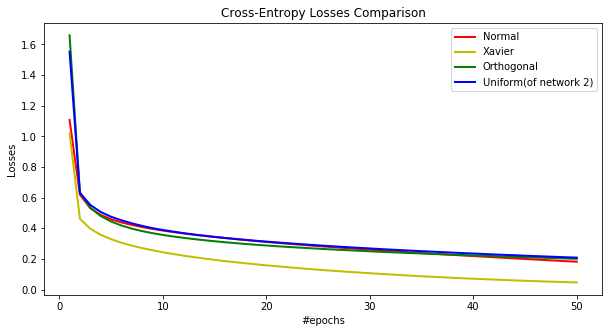

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 5))

l1,l2,l3,l4=plt.plot(range(1,51),[v[1] for v in normal_init],range(1,51),[v[1] for v in xavier_init],\
              range(1,51),[v[1] for v in ortho_init],range(1,51),[v[1] for v in train_2_loss])
plt.setp(l1,linewidth=2,color='r')
plt.setp(l2,linewidth=2,color='y')
plt.setp(l3,linewidth=2,color='g')
plt.setp(l4,linewidth=2,color='b')
plt.legend([l1,l2,l3,l4],['Normal','Xavier','Orthogonal','Uniform(of network 2)'])
plt.xlabel('#epochs')
plt.ylabel('Losses')
plt.title('Cross-Entropy Losses Comparison')
plt.show()


***
### Experiment 2 : Batch Normalization

**Applying BN layer after second hiddern layer:**

In [27]:
n_epochs=10
display_step=2
data_3 = mx.symbol.Variable('data')
fc1_3  = mx.symbol.FullyConnected(data = data_3, num_hidden=1024)
act1_3 = mx.symbol.Activation(data = fc1_3, act_type="relu")
#bn1_3 = mx.symbol.BatchNorm(data=act1_3)
fc2_3  = mx.symbol.FullyConnected(data = act1_3, num_hidden = 512)
act2_3 = mx.symbol.Activation(data = fc2_3, act_type="relu")
bn2_3 = mx.symbol.BatchNorm(data=act2_3)
fc3_3  = mx.symbol.FullyConnected(data = bn2_3, num_hidden = 256)
act3_3 = mx.symbol.Activation(data = fc3_3, act_type="relu")
#bn3_3 = mx.symbol.BatchNorm(data=act3_3)
#output layer
fc4_3  = mx.symbol.FullyConnected(data = act3_3, num_hidden=10)
mlp_3 = mx.symbol.SoftmaxOutput(data = fc4_3,name='softmax')


bn=[]
mod_3 = mx.mod.Module(symbol=mlp_3,
                    context=mx.cpu(),
                    data_names=['data'],
                    label_names=['softmax_label'])

# allocate memory given the input data and label shapes
mod_3.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
mod_3.init_params(mx.initializer.Uniform(scale=0.1))
learn_rate=0.001
mod_3.init_optimizer(optimizer='sgd', optimizer_params=(('learning_rate', learn_rate), ))
# use accuracy as the metric
metric = mx.metric.CrossEntropy()
metric2= mx.metric.create('acc')
for epoch in range(n_epochs):
    train_iter.reset()
    metric.reset()
    metric2.reset()
    for batch in train_iter:
        mod_3.forward(batch, is_train=True)       # compute predictions
        mod_3.update_metric(metric, batch.label)  # accumulate prediction loss
        mod_3.update_metric(metric2, batch.label)  # accumulate prediction accuracy
        mod_3.backward()                          # compute gradients
        mod_3.update()                            # update parameters
    loss=metric.get()
    acc=metric2.get()
    bn.append(loss)
    if epoch%display_step==0 or epoch==n_epochs-1:
        print('Epoch %d, Training %s' % (epoch+1,acc))

Epoch 1, Training ('accuracy', 0.59114285714285719)
Epoch 3, Training ('accuracy', 0.78261904761904766)
Epoch 5, Training ('accuracy', 0.80840476190476196)
Epoch 7, Training ('accuracy', 0.82269047619047619)
Epoch 9, Training ('accuracy', 0.83388095238095239)
Epoch 10, Training ('accuracy', 0.83797619047619043)


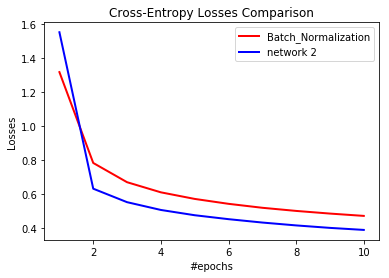

In [30]:
l1,l2=plt.plot(range(1,11),[v[1] for v in bn],range(1,11),[v[1] for v in train_2_loss[:10]])
plt.setp(l1,linewidth=2,color='r')
plt.setp(l2,linewidth=2,color='b')
plt.legend([l1,l2],['Batch_Normalization','network 2'])
plt.xlabel('#epochs')
plt.ylabel('Losses')
plt.title('Cross-Entropy Losses Comparison')
plt.show()

In [31]:
mod_3.save_params('batch_norm')

***
### Experiment 3: Regularizations

- Dropouts applied on middle layer only

In [36]:
regs=[0.1,0.4,0.6]
n_epochs=10
display_step=5
drop_loss=[]

for reg in regs:
    drop=[]
    data_4 = mx.symbol.Variable('data')
    fc1_4  = mx.symbol.FullyConnected(data = data_4, num_hidden=1024)
    act1_4 = mx.symbol.Activation(data = fc1_4, act_type="relu")
    #dr1_4 = mx.symbol.Dropout(data=act1_4,p=reg)
    fc2_4  = mx.symbol.FullyConnected(data = act1_4, num_hidden = 512)
    act2_4 = mx.symbol.Activation(data = fc2_4, act_type="relu")
    dr2_4 = mx.symbol.Dropout(data=act2_4,p=reg)
    fc3_4  = mx.symbol.FullyConnected(data = dr2_4, num_hidden = 256)
    act3_4 = mx.symbol.Activation(data = fc3_4, act_type="relu")
    #dr3_4 = mx.symbol.Dropout(data=act3_4,p=reg)
    #output layer
    fc4_4  = mx.symbol.FullyConnected(data = act3_4, num_hidden=10)
    mlp_4 = mx.symbol.SoftmaxOutput(data = fc4_4,name='softmax')


    bn=[]
    mod_4 = mx.mod.Module(symbol=mlp_4,
                        context=mx.cpu(),
                        data_names=['data'],
                        label_names=['softmax_label'])

    # allocate memory given the input data and label shapes
    mod_4.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
    mod_4.init_params(mx.initializer.Uniform(scale=0.1))
    learn_rate=0.001
    mod_4.init_optimizer(optimizer='sgd', optimizer_params=(('learning_rate', learn_rate), ))
    # use accuracy as the metric
    metric = mx.metric.CrossEntropy()
    metric2= mx.metric.create('acc')
    for epoch in range(n_epochs):
        train_iter.reset()
        metric.reset()
        metric2.reset()
        for batch in train_iter:
            mod_4.forward(batch, is_train=True)       # compute predictions
            mod_4.update_metric(metric, batch.label)  # accumulate prediction loss
            mod_4.update_metric(metric2, batch.label)  # accumulate prediction accuracy
            mod_4.backward()                          # compute gradients
            mod_4.update()                            # update parameters
        loss=metric.get()
        acc=metric2.get()
        drop.append(loss)
        if epoch%display_step==0 or epoch==n_epochs-1:
            print('Epoch %d, Training %s' % (epoch+1,acc))
    drop_loss.append(drop)
    mod_4.save_params('dropout_'+str(reg))

Epoch 1, Training ('accuracy', 0.66302380952380957)
Epoch 6, Training ('accuracy', 0.79440476190476195)
Epoch 10, Training ('accuracy', 0.82199999999999995)
Epoch 1, Training ('accuracy', 0.63352380952380949)
Epoch 6, Training ('accuracy', 0.76245238095238099)
Epoch 10, Training ('accuracy', 0.78711904761904761)
Epoch 1, Training ('accuracy', 0.53900000000000003)
Epoch 6, Training ('accuracy', 0.67002380952380958)
Epoch 10, Training ('accuracy', 0.69714285714285718)


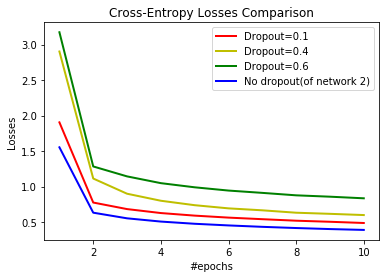

In [37]:
l1,l2,l3,l4=plt.plot(range(1,11),[v[1] for v in drop_loss[0]],range(1,11),[v[1] for v in drop_loss[1]],\
              range(1,11),[v[1] for v in drop_loss[2]],range(1,11),[v[1] for v in train_2_loss[:10]])
plt.setp(l1,linewidth=2,color='r')
plt.setp(l2,linewidth=2,color='y')
plt.setp(l3,linewidth=2,color='g')
plt.setp(l4,linewidth=2,color='b')
plt.legend([l1,l2,l3,l4],['Dropout=0.1','Dropout=0.4','Dropout=0.6','No dropout(of network 2)'])
plt.xlabel('#epochs')
plt.ylabel('Losses')
plt.title('Cross-Entropy Losses Comparison')
plt.show()

***
### Experiment 4: Optimizers

In [40]:
opts=['adam','nag','rmsprop','adadelta','adagrad']
n_epochs=10
display_step=5
optm_loss=[]
data_5 = mx.symbol.Variable('data')
fc1_5  = mx.symbol.FullyConnected(data = data_5, num_hidden=1024)
act1_5 = mx.symbol.Activation(data = fc1_5, act_type="relu")
fc2_5  = mx.symbol.FullyConnected(data = act1_5, num_hidden = 512)
act2_5 = mx.symbol.Activation(data = fc2_5, act_type="relu")
fc3_5  = mx.symbol.FullyConnected(data = act2_5, num_hidden = 256)
act3_5 = mx.symbol.Activation(data = fc3_5, act_type="relu")
#output layer
fc4_5  = mx.symbol.FullyConnected(data = act3_5, num_hidden=10)
mlp_5 = mx.symbol.SoftmaxOutput(data = fc4_5,name='softmax')

learn_rate=0.001

for opt in opts:
    mod_5 = mx.mod.Module(symbol=mlp_5,
                    context=mx.cpu(),
                    data_names=['data'],
                    label_names=['softmax_label'])

    # allocate memory given the input data and label shapes
    mod_5.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
    mod_5.init_params(mx.initializer.Uniform(scale=0.1))
    o_loss=[]
    mod_5.init_optimizer(optimizer=opt, optimizer_params=(('learning_rate', learn_rate), ))
    # use accuracy as the metric
    metric = mx.metric.CrossEntropy()
    metric2= mx.metric.create('acc')
    for epoch in range(n_epochs):
        train_iter.reset()
        metric.reset()
        metric2.reset()
        for batch in train_iter:
            mod_5.forward(batch, is_train=True)       # compute predictions
            mod_5.update_metric(metric, batch.label)  # accumulate prediction loss
            mod_5.update_metric(metric2, batch.label)  # accumulate prediction accuracy
            mod_5.backward()                          # compute gradients
            mod_5.update()                            # update parameters
        loss=metric.get()
        acc=metric2.get()
        o_loss.append(loss)
        if epoch%display_step==0 or epoch==n_epochs-1:
            print('Epoch %d, Training %s' % (epoch+1,acc))
    optm_loss.append(o_loss)
    mod_5.save_params('optimizer_'+opt)

Epoch 1, Training ('accuracy', 0.75983333333333336)
Epoch 6, Training ('accuracy', 0.87764285714285717)
Epoch 10, Training ('accuracy', 0.88804761904761909)
Epoch 1, Training ('accuracy', 0.70021428571428568)
Epoch 6, Training ('accuracy', 0.84319047619047616)
Epoch 10, Training ('accuracy', 0.86304761904761906)
Epoch 1, Training ('accuracy', 0.67138095238095241)
Epoch 6, Training ('accuracy', 0.84159523809523806)
Epoch 10, Training ('accuracy', 0.85576190476190472)
Epoch 1, Training ('accuracy', 0.53680952380952385)
Epoch 6, Training ('accuracy', 0.78890476190476189)
Epoch 10, Training ('accuracy', 0.83161904761904759)
Epoch 1, Training ('accuracy', 0.76226190476190481)
Epoch 6, Training ('accuracy', 0.87385714285714289)
Epoch 10, Training ('accuracy', 0.90359523809523812)


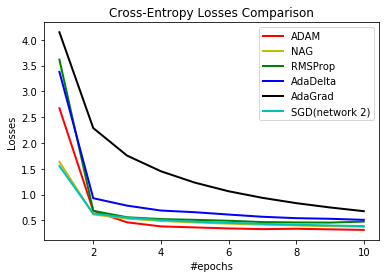

In [44]:
l1,l2,l3,l4,l5,l6=plt.plot(range(1,11),[v[1] for v in optm_loss[0]],range(1,11),[v[1] for v in optm_loss[1]],\
              range(1,11),[v[1] for v in optm_loss[2]],range(1,11),[v[1] for v in optm_loss[3]],\
                     range(1,11),[v[1] for v in optm_loss[4]],range(1,11),[v[1] for v in train_2_loss[:10]])
plt.setp(l1,linewidth=2,color='r')
plt.setp(l2,linewidth=2,color='y')
plt.setp(l3,linewidth=2,color='g')
plt.setp(l4,linewidth=2,color='b')
plt.setp(l5,linewidth=2,color='k')
plt.setp(l6,linewidth=2,color='c')
plt.legend([l1,l2,l3,l4,l5,l6],['ADAM','NAG','RMSProp','AdaDelta','AdaGrad','SGD(network 2)'])
plt.xlabel('#epochs')
plt.ylabel('Losses')
plt.title('Cross-Entropy Losses Comparison')
plt.show()